## Tree-based regression

- Pros: Fits complex, nonlinear data
- Cons: Difficult to interpret results
- Works with: Numeric values, nominal values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implement DecisionTreeRegressor

In [2]:
# class treeNode():
# def __init__(self, feat, val, right, left):
#     featureToSplitOn = feat
#     valueOfSplit = val
#     rightBranch = right
#     leftBranch = left

In [3]:
# Regression tree split function
# For every feature:
#     For every unique value:
#         Split the dataset into two
#         Measure the error of the two splits
#         If the error is less than bestError
#           ➞ set bestSplit to this split and update bestError
# Return bestSplit feature and threshold
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0]]
    mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0]]
    return mat0, mat1


def regLeaf(dataSet):
    return np.mean(dataSet[:, -1])


def regErr(dataSet):
    return np.var(dataSet[:, -1]) * np.shape(dataSet)[0]


def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    # user-defined settings that tell the function
    # when to quit creating new splits
    tolS, tolN = ops[0], ops[1]
    # Exit if all values are equal
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:
        return None, leafType(dataSet)
    m, n = np.shape(dataSet)
    S = errType(dataSet)
    bestS, bestIndex, bestValue = np.inf, 0, 0
    for featIndex in range(n - 1):
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if np.shape(mat0)[0] < tolN or np.shape(mat1)[0] < tolN:
                continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # Exit if low error reduction
    if (S - bestS) < tolS:
        return None, leafType(dataSet)
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # Exit if split creates small dataset
    if np.shape(mat0)[0] < tolN or np.shape(mat1)[0] < tolN:
        return None, leafType(dataSet)
    return bestIndex, bestValue

In [4]:
# CART tree-building code
# Find the best feature to split on:
#      If we can’t split the data, this node becomes a leaf node
#      Make a binary split of the data
#      Call createTree() on the right split of the data
#      Call createTree() on the left split of the data
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    # Return leaf value if stopping condition met
    if feat is None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

In [5]:
# Regression tree-pruning functions
# Split the test data for the given tree:
#     If the either split is a tree: call prune on that split
#     Calculate the error associated with merging two leaf nodes
#     Calculate the error without merging
#     If merging results in lower error then merge the leaf nodes
def isTree(obj):
    return isinstance(obj, dict)


def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left'] + tree['right']) / 2


def prune(tree, testData):
    # Collapse tree if no test data
    if np.shape(testData)[0] == 0:
        return getMean(tree)
    if isTree(tree['right']) or isTree(tree['left']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        errorNoMerge = (sum(np.power(lSet[:, -1] - tree['left'], 2)) +
                        sum(np.power(rSet[:, -1] - tree['right'], 2)))
        treeMean = (tree['left'] + tree['right']) / 2
        errorMerge = sum(np.power(testData[:, -1] - treeMean, 2))
        if errorMerge < errorNoMerge:
            print("merging")
            return treeMean
        else:
            return tree
    else:
        return tree

In [6]:
# Leaf-generation function for model trees
def linearSolve(dataSet):
    m, n = np.shape(dataSet)
    # Format data in X and Y
    X = np.mat(np.ones((m, n)))
    Y = np.mat(np.ones((m, 1)))
    X[:, 1: n] = dataSet[:, 0: n - 1]
    Y = dataSet[:, -1]
    xTx = X.T * X
    if np.linalg.det(xTx) == 0.0:
        raise NameError("This matrix is singular, cannot do inverse,\n"
                        "try increasing the second value of ops")
    ws = xTx.I * (X.T * Y)
    return ws, X, Y


def modelLeaf(dataSet):
    ws, _, _ = linearSolve(dataSet)
    return ws


def modelErr(dataSet):
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(np.power(Y - yHat, 2))

In [7]:
# Code to create a forecast with tree-based regression
def regTreeEval(model, inDat):
    return float(model)


def modelTreeEval(model, inDat):
    n = np.shape(inDat)[1]
    X = np.mat(np.ones((1, n + 1)))
    X[:, 1: n + 1] = inDat
    return float(X * model)


def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree):
        return modelEval(tree, inData)
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)


def createForeCast(tree, testData, modelEval=regTreeEval):
    m = len(testData)
    yHat = np.mat(np.zeros((m, 1)))
    for i in range(m):
        yHat[i, 0] = treeForeCast(tree, np.mat(testData[i]), modelEval)
    return yHat

### Experiment 1: Toy dataset

In [8]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        # Map everything to float()
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

In [9]:
myDat = loadDataSet('ex00.txt')
myMat = np.mat(myDat)

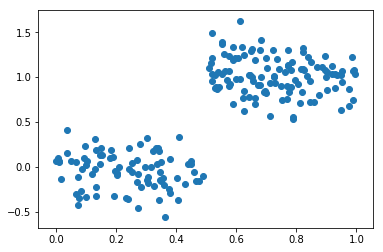

In [10]:
plt.figure()
plt.scatter(myMat[:, 0].A, myMat[:, 1].A)
plt.show()

In [11]:
createTree(myMat)

{'left': 1.0180967672413792,
 'right': -0.04465028571428572,
 'spInd': 0,
 'spVal': 0.48813}

In [12]:
myDat1 = loadDataSet('ex0.txt')
myMat1 = np.mat(myDat1)

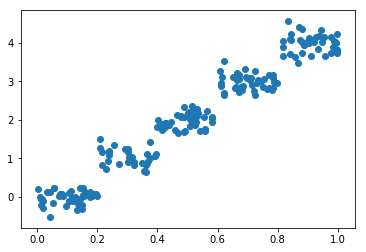

In [13]:
# Feature 0 is constant
plt.figure()
plt.scatter(myMat1[:, 1].A, myMat1[:, 2].A)
plt.show()

In [14]:
createTree(myMat1)

{'left': {'left': {'left': 3.9871632,
   'right': 2.9836209534883724,
   'spInd': 1,
   'spVal': 0.797583},
  'right': 1.980035071428571,
  'spInd': 1,
  'spVal': 0.582002},
 'right': {'left': 1.0289583666666666,
  'right': -0.023838155555555553,
  'spInd': 1,
  'spVal': 0.197834},
 'spInd': 1,
 'spVal': 0.39435}

In [15]:
# Regression tree-pruning functions

In [16]:
myDat2 = loadDataSet('ex2.txt')
myMat2 = np.mat(myDat2)

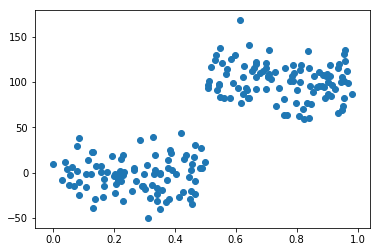

In [17]:
plt.figure()
plt.scatter(myMat2[:, 0].A, myMat2[:, 1].A)
plt.show()

In [18]:
createTree(myMat2, ops=(10000, 4))

{'left': 101.35815937735848,
 'right': -2.637719329787234,
 'spInd': 0,
 'spVal': 0.499171}

In [19]:
myTree = createTree(myMat2, ops=(100, 4))
myDatTest = loadDataSet('ex2test.txt')
myMat2Test = np.mat(myDatTest)
print(prune(myTree, myMat2Test))

merging
merging
merging
merging
merging
merging
{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': 105.24862350000001, 'right': 112.42895575000001}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 87.3103875, 'right': 98.72274562962963}, 'right': {'spInd': 0, 'spVal': 0.811602, 'left': 81.110152, 'right': 88.78449880000001}}, 'right': 102.35780185714285}, 'right': 78.08564325}}, 'right': {'spInd': 0, 'spVal': 0.640515, 'left': 111.17352005263159, 'right': {'spInd': 0, 'spVal': 0.613004, 'left': 93.67344971428572, 'right': {'spInd': 0, 'spVal': 0.582311, 'left': 123.2101316, 'right': 101.580533}}}}, 'right': {'spInd': 0, 'spVal': 0.457563, 'left': 7.969946125, 'right': {'spInd': 0, 'spVal': 0.126833, 'left': {'spInd': 0, 'spVal': 0.373501, 'left': {'spInd': 0, 

In [20]:
# Leaf-generation function for model trees

In [21]:
myMat2 = np.mat(loadDataSet('exp2.txt'))

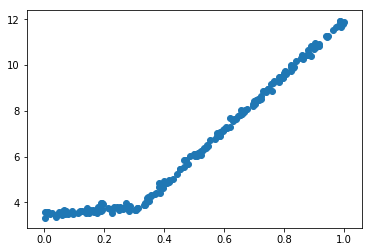

In [22]:
plt.figure()
plt.scatter(myMat2[:, 0].A, myMat2[:, 1].A)
plt.show()

In [23]:
createTree(myMat2, modelLeaf, modelErr, (1, 10))

{'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]]), 'spInd': 0, 'spVal': 0.285477}

### Experiment 2: Bicycle dataset

In [24]:
trainMat = np.mat(loadDataSet('bikeSpeedVsIq_train.txt'))
testMat = np.mat(loadDataSet('bikeSpeedVsIq_test.txt'))

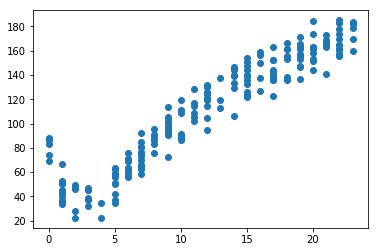

In [25]:
plt.figure()
plt.scatter(trainMat[:, 0].A, trainMat[:, 1].A)
plt.show()

In [26]:
myTree = createTree(trainMat, ops=(1, 20))
yHat = createForeCast(myTree, testMat[:, 0])
np.corrcoef(yHat, testMat[:, 1], rowvar=False)[0, 1]

0.964085231822215

In [27]:
myTree = createTree(trainMat, modelLeaf, modelErr, (1, 20))
yHat = createForeCast(myTree, testMat[:, 0], modelTreeEval)
np.corrcoef(yHat, testMat[:, 1], rowvar=False)[0, 1]

0.9760412191380629

In [28]:
ws, _, _ = linearSolve(trainMat)
yHat = np.zeros((np.shape(testMat)[0], 1))
for i in range(np.shape(testMat)[0]):
    yHat[i] = testMat[i, 0] * ws[1, 0] + ws[0, 0]
np.corrcoef(yHat, testMat[:, 1], rowvar=False)[0, 1]

0.9434684235674766